## Characterizing Fibers (coating and missing fibers)

The approach is to use two modules from skimage.feature package (SIFT and SURF) to learn how to characterize the coating of the fibers as well as use this information to be able to determine whether the image depicts a fiber or not.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt #similar to io.imshow(edges), but with more details

In [2]:
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters, util

In [3]:
# Silvia's
ic_fiber = io.ImageCollection("Data/yes_fibers/*.tif")
ic_nofiber = io.ImageCollection("Data/no_fibers/*.tif")

In [4]:
# number of images per folder
print(np.size(ic_fiber.files),'',np.size(ic_nofiber.files))

29  29


### Daisy
As a first attempt, we applied daisy to see how the images would behave with this feature extraction.
#### A fake fiber

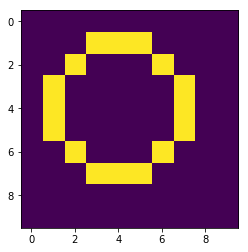

In [5]:
# create fake fiber
from skimage.draw import circle_perimeter

img_circle = np.zeros((10,10), dtype=np.uint8)
rr, cc = circle_perimeter(4,4,3)
img_circle[rr, cc] = 1
plt.imshow(img_circle)

#### Applying Daisy to fake fiber

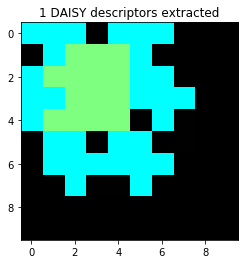

In [6]:
# apply daisy
from skimage.feature import daisy

descs, descs_img = daisy(img_circle, step = 180, radius = 3, rings = 2, histograms = 6,
                        orientations=8, visualize=True)
f, ax1 = plt.subplots()
#ax1.axis('off')
ax1.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax1.set_title('%i DAISY descriptors extracted' % descs_num)
plt.show()

#### Applying to all fibers

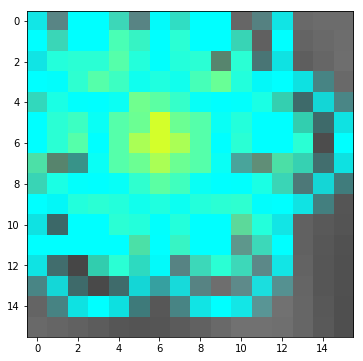

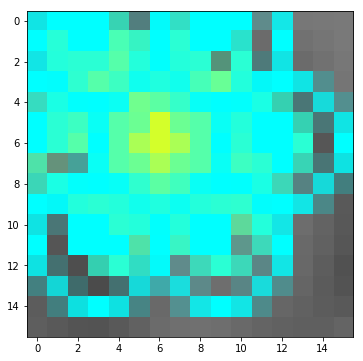

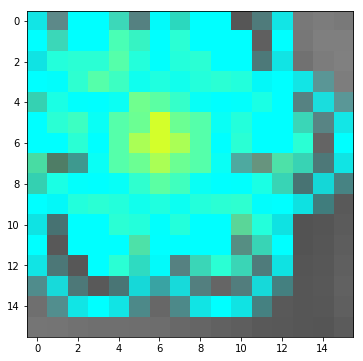

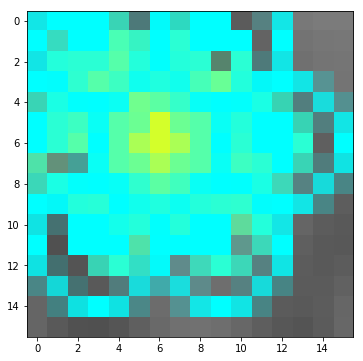

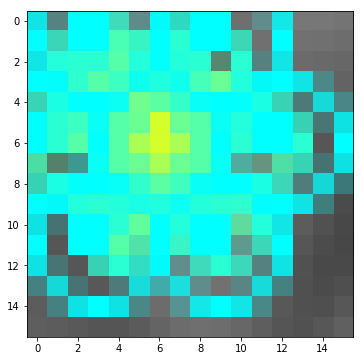

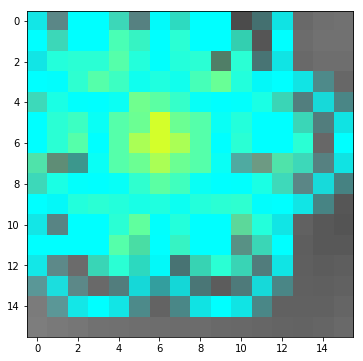

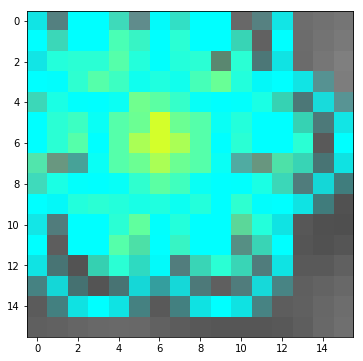

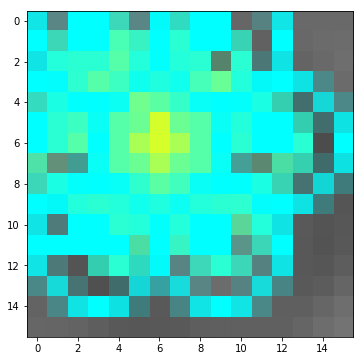

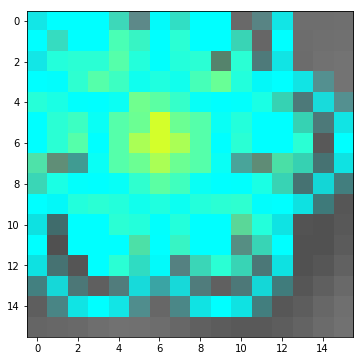

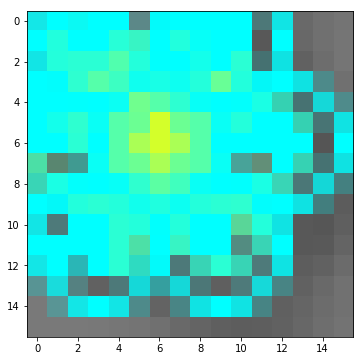

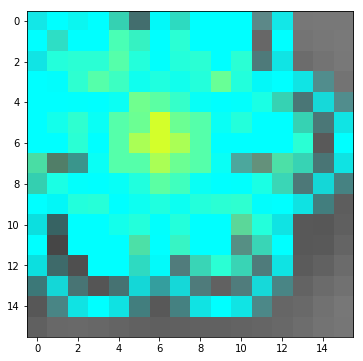

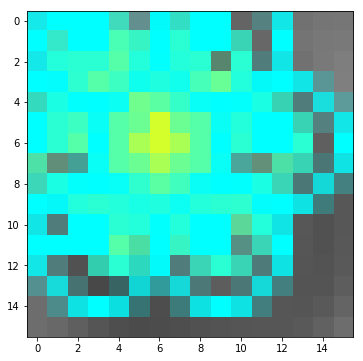

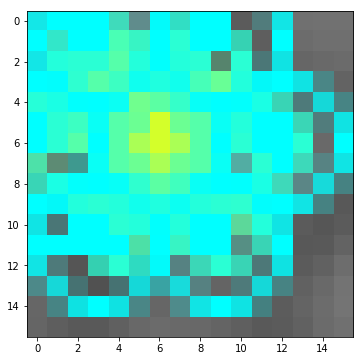

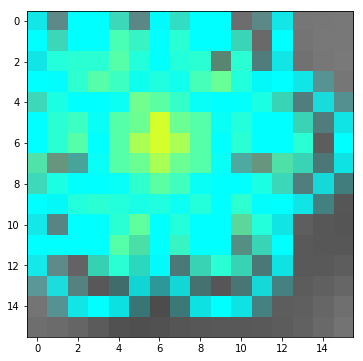

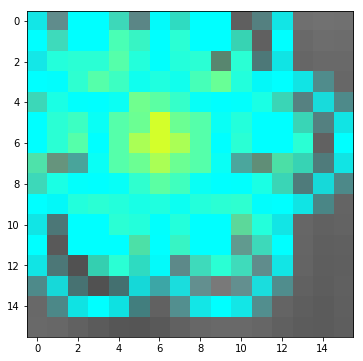

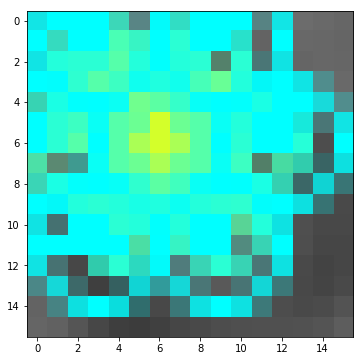

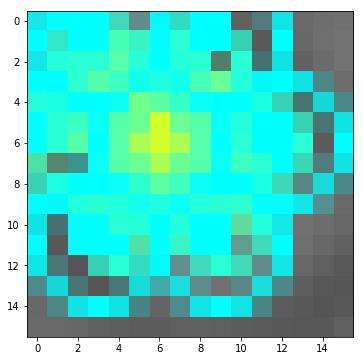

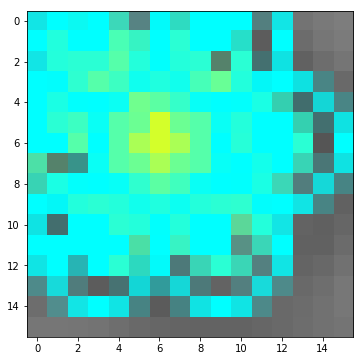

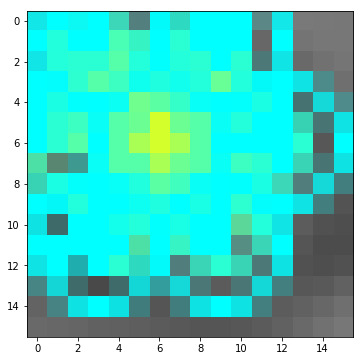

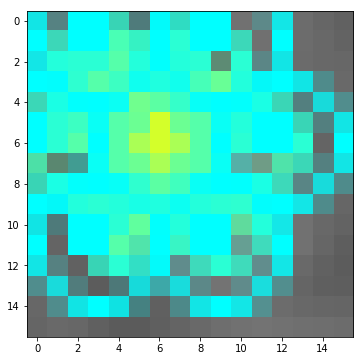

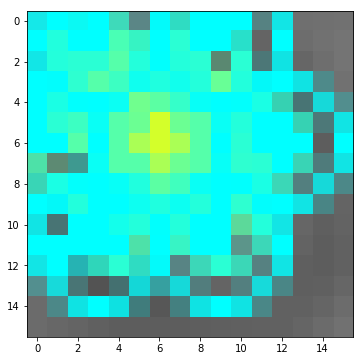

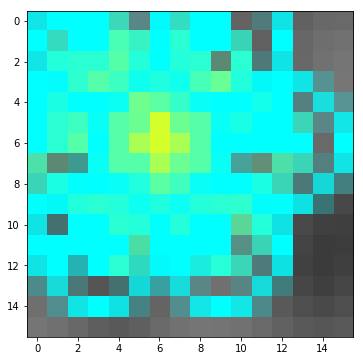

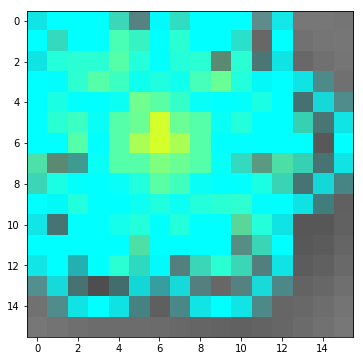

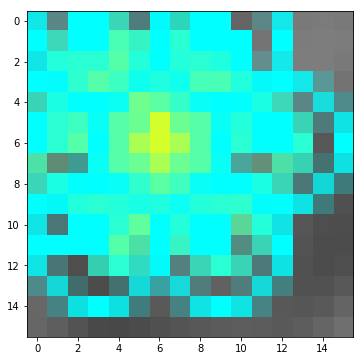

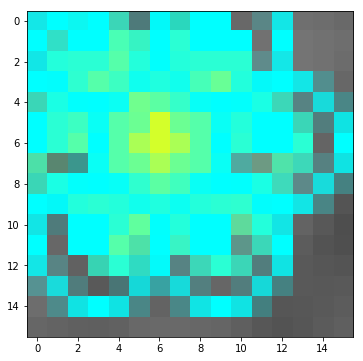

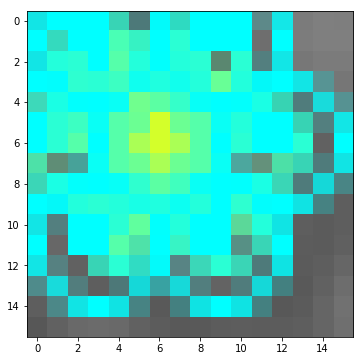

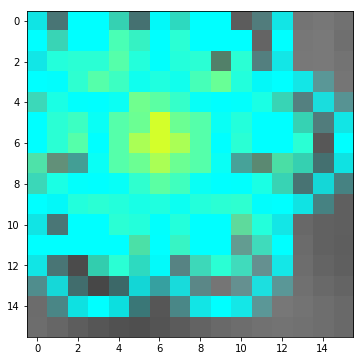

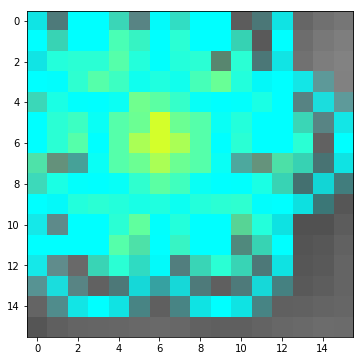

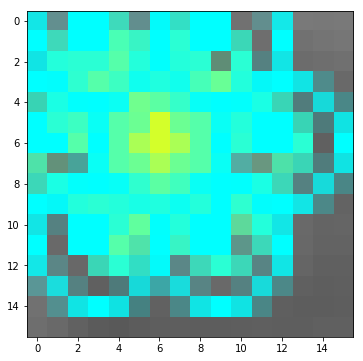

In [7]:
#one_image = ic_fiber[4]
#desc, desc_img = daisy(one_image, step=4, radius=6, rings = 6, histograms = 6,
                      #orientations=8, visualize=True)
# let's compare both images
#fi, a = plt.subplots()
#a.imshow(desc_img)
#plt.imshow(desc_img)
desc_all = []
for i, patch in enumerate(ic_fiber):
    descs, descs_img = daisy(patch, step=4, radius=6, rings=6, histograms=6,
                             orientations=8, visualize=True)
    #plt.subplot(8, 4, i+1)
    fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    ax.imshow(descs_img)
    desc_all.append(descs)
    plt.show()

##### Current state: Not very promising results using DAISY, given that the documentation does not give a lot of information about some of its applications. For now, we proceed with SURF and some of its methods. 

### SURF

As our first attempts we utilized 
1. Shape_index: Placing numbers according to the shape seen in the images (could potentially work), if lucky we could
    get "peaks" in the form of the circumference of the fiber.
2. Corner_orientations: Not really, because we are dealing with circles and not squares.
3. Blob_doh: Finds blobs in the given grayscale image (if lucky this could really work). T
4. ORB: Will return the best n_keypoints (maybe?)
5. Hessian Matrix det, maybe?

#### Recall our Fake Fiber


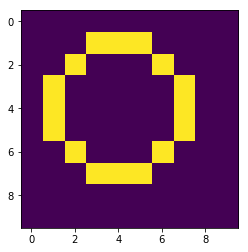

In [8]:
plt.imshow(img_circle)

#### Applying Shape_index (SURF)


/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/skimage/feature/corner.py:421: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/skimage/feature/corner.py:421: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


array([[        nan,         nan, -0.26772047,  0.39182655,  0.5       ,
         0.39182655, -0.26772047,         nan,         nan,         nan],
       [        nan, -0.5       , -0.5       ,  0.60817345,  0.87433408,
         0.60817345, -0.5       , -0.5       ,         nan,         nan],
       [-0.26772047, -0.5       ,  0.5       , -0.        , -0.5       ,
        -0.        ,  0.5       , -0.5       , -0.26772047,         nan],
       [ 0.39182655,  0.60817345, -0.        , -0.5       , -0.5       ,
        -0.5       , -0.        ,  0.59223083, -0.        , -0.5       ],
       [ 0.5       ,  0.87433408, -0.5       , -0.5       ,         nan,
        -0.5       , -0.5       , -1.        ,         nan, -0.5       ],
       [ 0.39182655,  0.60817345, -0.        , -0.5       , -0.5       ,
        -0.5       , -0.        ,  0.59223083, -0.        , -0.5       ],
       [-0.26772047, -0.5       ,  0.5       , -0.        , -0.5       ,
        -0.        ,  0.5       , -0.5       

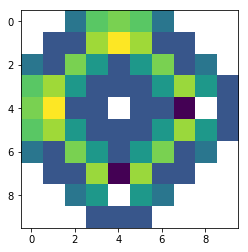

In [9]:
from skimage.feature import shape_index
s = shape_index(img_circle, sigma=0.1)
plt.imshow(s)
s

#### Applying to all Fibers
To find the specific area of interest (coating) one needs to come up with an approximation or major and minor axis so that we can bound and draw the approximated coating based on shape_index and estimated bounds.

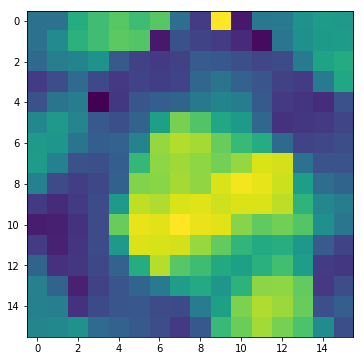

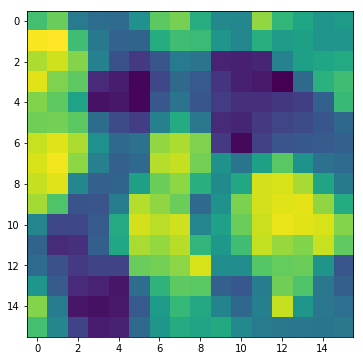

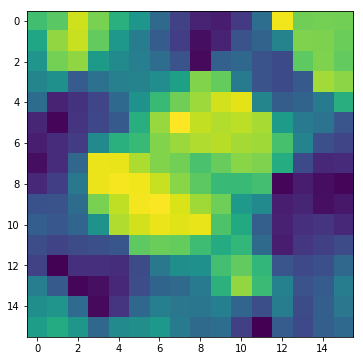

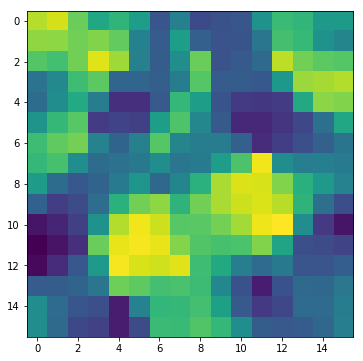

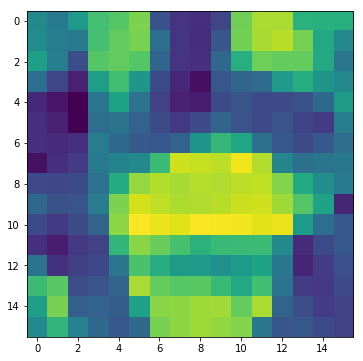

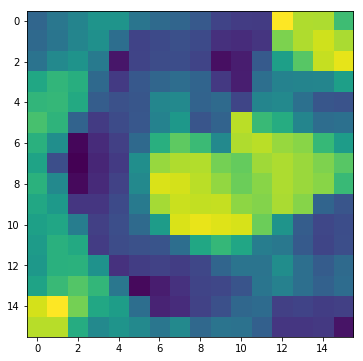

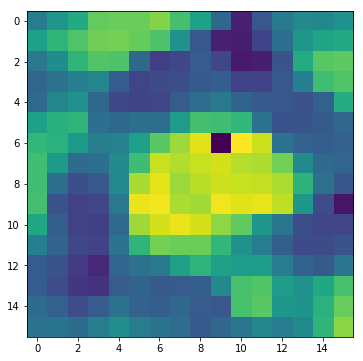

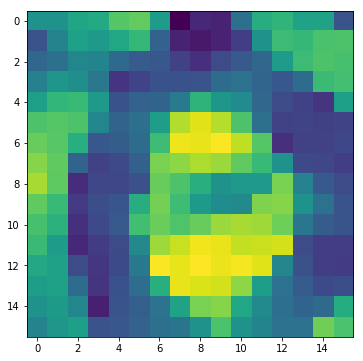

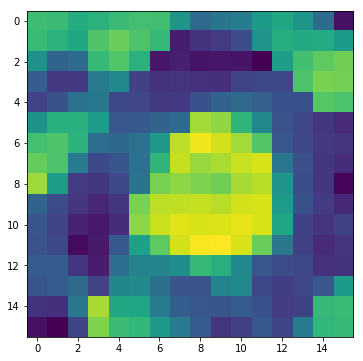

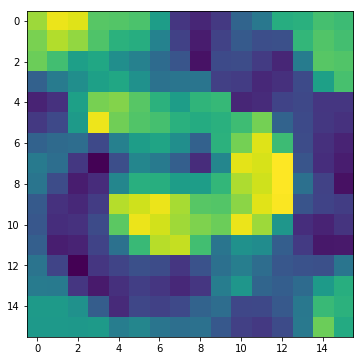

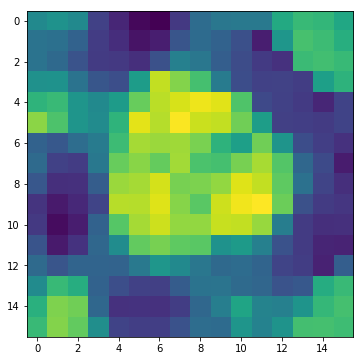

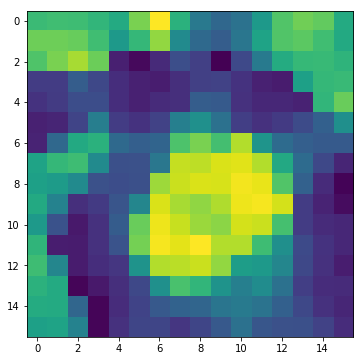

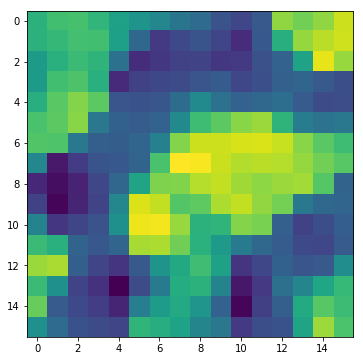

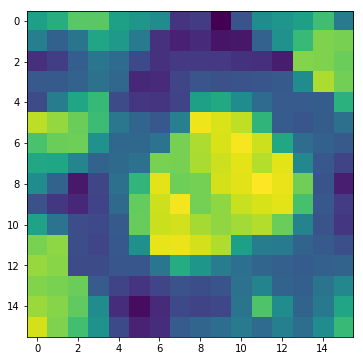

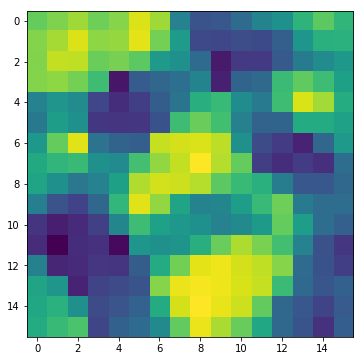

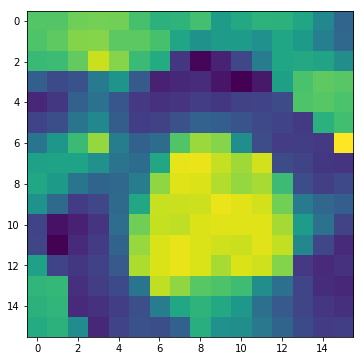

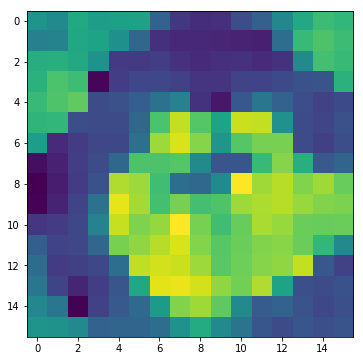

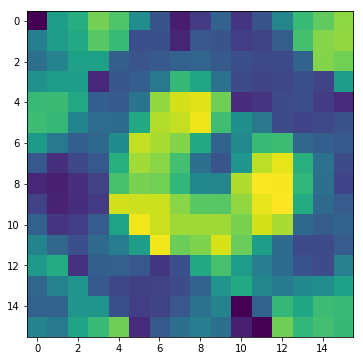

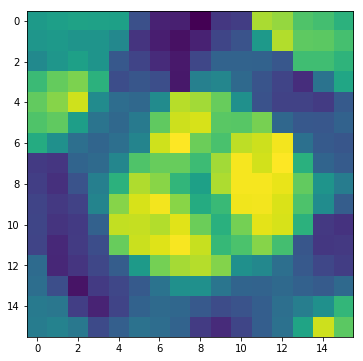

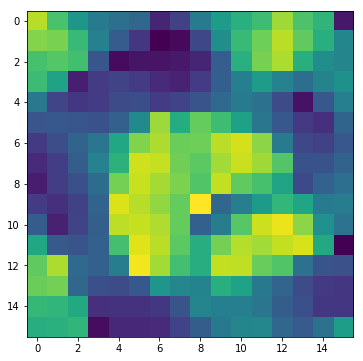

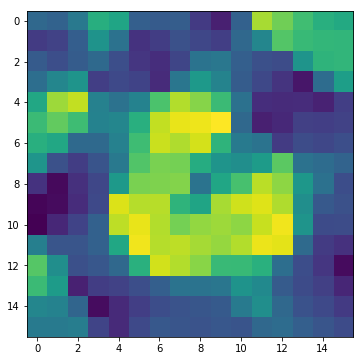

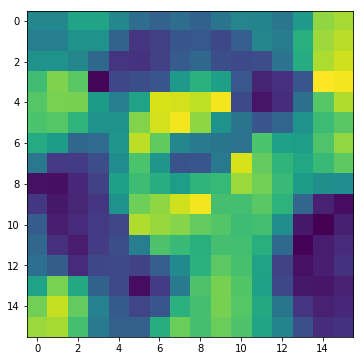

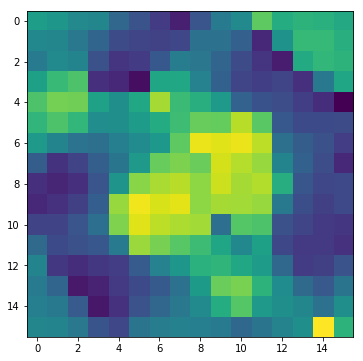

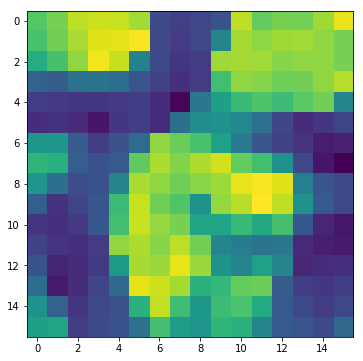

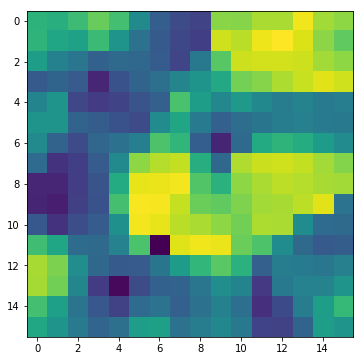

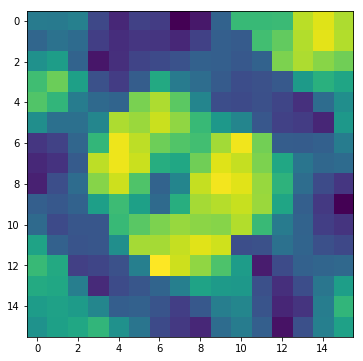

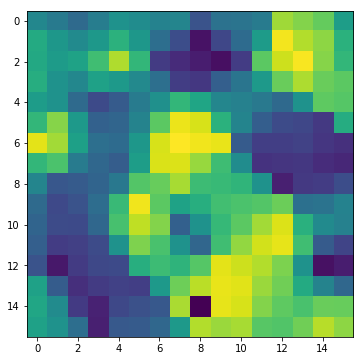

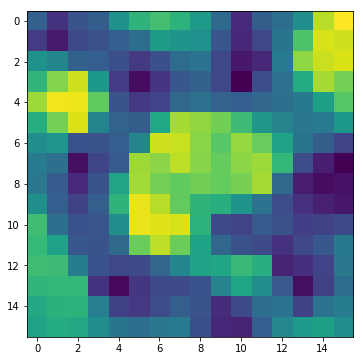

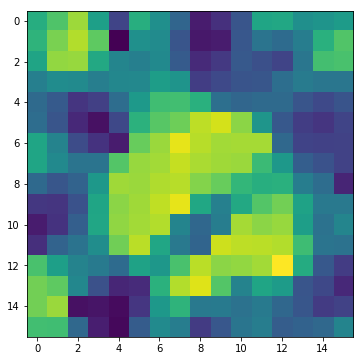

In [10]:
shapes = []
for i, patch in enumerate(ic_fiber):
    sh = shape_index(patch, sigma=0.1)
    shapes.append(sh)
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    ax2.imshow(sh)
    plt.show()

#### Applying Blob_doh
The promise of this feature descriptor is that, by drawing "circles" on the "detected" border/coating, once we introduce fibers that look like and ellipse, we would be able to detect the coating of those fibers as well. 
    From here, can we somehow extract the feature of the detected coating so that we are able to tell whether there 
    is an existing fiber in a given image. 


##### Fake fiber

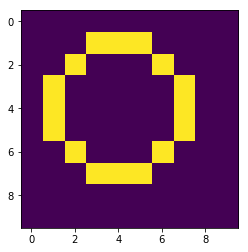

In [11]:
plt.imshow(img_circle)

In [12]:
# attempting to apply the blob_doh here
feature.blob_doh(img_circle)

array([], shape=(0, 3), dtype=float64)

#### Blob_doh

#### Applying to all fibers
There seems to be an error here, when attempting to print all the "blobs" we detected, the only value we get in return is an empty array.

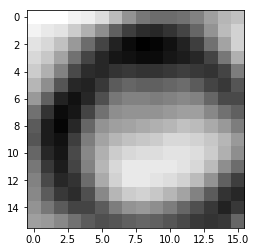

In [14]:
### Let's find an ideal fiber to work with (from the og data) (4,, 6, 8, 10(almost compelte), 11 (complete, def), 13 (better),
# 16 (best by far), 18 (compare with 16))

plt.imshow(ic_fiber[16], cmap='gray')



Let's try with fiber 16 to see if the Determinant of Hessian can detect this blob

We are not showing anything because, we need an actual approximation of the radius of these fibers. We don't have that measurement. All we can do is guesstimate the radius for a stack of images.
But in the bigger pictue, how are gonna do that? Isn't the whole thing we are trying to do is for us to find the radius through another algorithm?
I'll keep working.

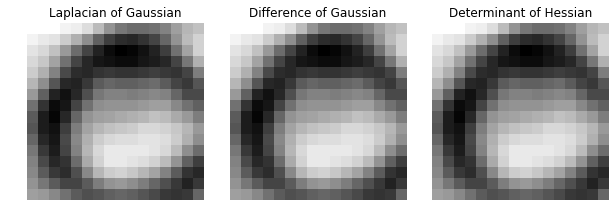

In [15]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = ic_fiber[16]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=18, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=18, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=18, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest', cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

#### Problem: Blob_doh or any Blob_.. is not detecting the blobs within the given image.
(Trying to extract the blobs found..feature extraction..but we are not detecting anything...why?)

The reason that this might be happening is because there is no clear background and foreground? so the intensity of these might not be changing sufficiently for the algorithm to detect them. 
Possible new approaches:
1. Can you apply something to the images so that the ring is even more evident? or the borders darker?
2. How does the hubble image look like when its turned to gray? 
3. Can you really see background and foreground? 
4. Does the image quality alter this?
5. Can you obtain the matrix of the gray image and obtain the border as a feature? an draw a circle based on that border? 
    1. If this works, keep in mind that you would need to establish a
        range beteween the circle diameter in case another circle is 
         drawn that you need to throw away 
Drew an actual "blob" and nothing was detected. Need to research what
is causing this error. 
If I actually move forward into applying a mask, would that really help? (given that it didnt work in the actual blob I drew). This is why it is important to see how the Hubble image looks, and the type of input we are passing into blob_doh. 

The next step would be to google any source of error for this algorithm.

### Making images more clear
That is, making the borders more distinctive. Threshold according to otsu, the resulting inequality is your binary image.

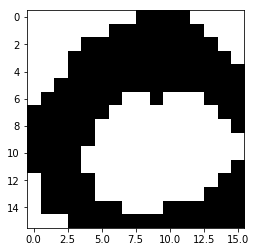

In [16]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(image)
bin_image = image>thresh_val
plt.imshow(bin_image, cmap="gray")

Looking at all the values in the image (ic_fiber[16]), how can we make these borders easier to detect?

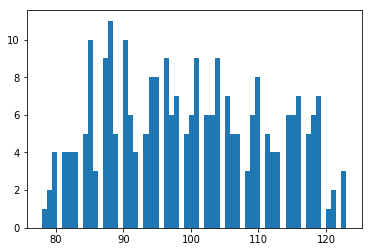

In [17]:
plt.hist(image.flatten(), bins = 60);


**NOTE**:To analyze the values of an image, plt.plot(img[:200]) or something to see where the values go dark or white.

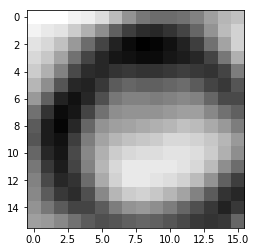

In [18]:
plt.imshow(ic_fiber[16], cmap='gray')

### Convert the values of the image from white to dark and viceversa
Would this make everything easier? That is, will this help the algorithms detect the edges with less difficulty?

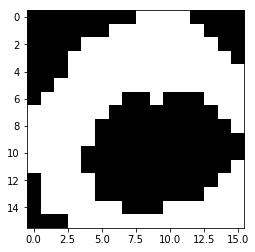

In [19]:
# use np.invert
bin_inverted = np.invert(bin_image)
plt.imshow(bin_inverted, cmap='gray')

We now attempt to use some of the algorithms from skimage to draw circles in the white borders.

#### Blob_doh (again)

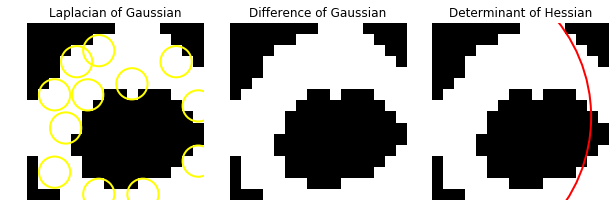

In [20]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

im = bin_inverted
image_gray = rgb2gray(bin_inverted)

blobs_log = blob_log(image_gray)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(im, interpolation='nearest', cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Conclusion: Looks like even after making the edges a bit more clear,the blob_doh algorithm (with all 3 of its extensions) does not work for these images. A possible issue coud be the lack of clarity in the given images (pixelated).


*ANOTHER NOTE: READ FURTHER IN DOCUMENTATION AS FAR AS PARAMETERS GO TO MAKE THIS WORK*

### Drawing a cirlce according to the values of the thresholded image
The purpose of this first step is to approximate the radius of all fibers, and approximately draw a circle given the calculated radius. The algorithm goes as follows:
1. An image is inputted 
2. This image is thresholded to enhance the borders of it.
3. We invert the image so that the edge is white and the empty space (background) is black.
4. The coordinates of the points where the image is white (edges) are obtained.
5. We fill the holes of the binary image so that the centroid can be calculated without being affected by the number of points detected in the edge.
6. The centroid is calculated from the filled binary image so that is less biased towards a dense amount of points.
7. After obtaining the centroid, we proceed to calculate the distances from this centroid to four sections of the fiber.
8. These are all stored in arrays and then concatenated.
9. We plot the distribution of the radii
10. Calculate the mean, and select the radii following the mean to draw in original image.

So the image we have by far is this one. Here the edges are white.

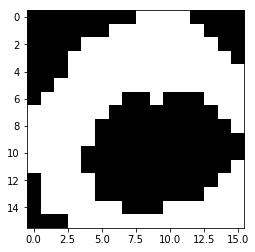

In [21]:
plt.imshow(bin_inverted, cmap = 'gray')

We proceed to find where the white pixels are located in the inverted image (recall 255 is white)

In [22]:
# returns 2 arrays (x-coords of white pixels and y-coords of white pixels)
coords_edges = np.where(bin_inverted == [True])
coords_zip = list(zip(coords_edges[0], coords_edges[1]))
coords_array = np.asarray(coords_zip) # all white points
coords_array

array([[ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 3,  3],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7],
       [ 3,  8],
       [ 3,  9],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 3, 14],
       [ 4,  3],
       [ 4,  4],
       [ 4,  5],
       [ 4,  6],
       [ 4,  7],
       [ 4,  8],
       [ 4,  9],
       [ 4, 10],
       [ 4, 11],
       [ 4, 12],
       [ 4, 13],
       [ 4, 14],
       [ 4, 15],
       [ 5,  2],
       [ 5,  3],
       [ 5,  4],
       [ 5,  5],
       [ 5,  6],
       [ 5,  7],
       [ 5,  8],
       [ 5,  9],
       [ 5, 10],
       [ 5, 11],
       [ 5, 12],
       [ 5, 13],
       [ 5, 14

Computing the centroid using scipy (FAILED)

In [23]:
from scipy import ndimage
x, y = ndimage.measurements.center_of_mass(coords_array)
x, y

(78.74962889658585, 0.49777337951509154)

Centroid calculation was off, for some reason? Perhaps I am missing an important aspect of the input image. Attempt #2 is by creating a function that actually calculates the center of mass. 

In [24]:
def centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [25]:
x_2,y_2 = centroid(coords_array)
x_2, y_2

(7.463235294117647, 7.397058823529412)

Now..we plot?

Compute the centroid from the set of points obtained above and draw a mark at that center to see if it seems accurate/correct and plot

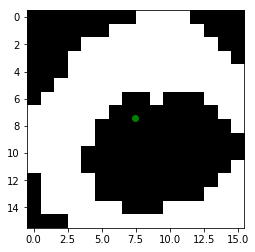

In [26]:
plt.imshow(bin_inverted, cmap = 'gray')
plt.plot(x_2, y_2, 'go')

How can we improve the center? To avoid the natural mathematical behavior of CoM, fill in the donut drawn after thresholding the image, and to then draw the circle? All of this is to improve the calculated centroid.

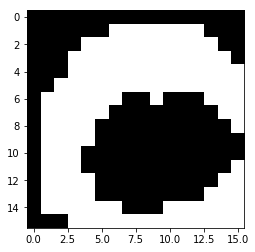

In [27]:
# filling edges

from scipy.ndimage.morphology import binary_closing, binary_fill_holes
all_closed = binary_closing(bin_inverted, structure = np.ones((2,2)))
plt.imshow(all_closed, cmap='gray')


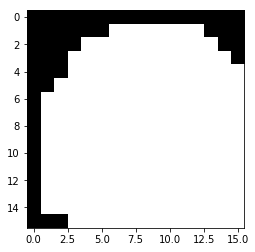

In [28]:
# filling the center (still have to find out how the 'structure' parameter is supposed to work with this method)

closed_too = binary_fill_holes(all_closed, structure=np.ones((3,1)))
plt.imshow(closed_too, cmap = 'gray')

Now we recalculate the center of mass with the filled hole to see whether or not the densities for the moments were affected (my hypothesis is that they will be affected).

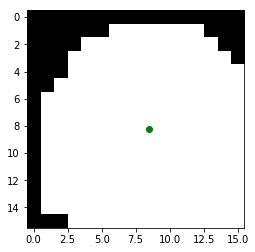

In [29]:
# your new image is: "closed too"

all_white= np.where(closed_too == [True])
filled_zip = list(zip(all_white[0], all_white[1]))
filled_array = np.asarray(filled_zip)

# now we compute the centroid
x_white, y_white = centroid(filled_array)

# now we plot
plt.imshow(closed_too, cmap = 'gray')
plt.plot(x_white, y_white, 'go')

##### AWESOME!
Now that you have the more exact coordinates fo the center of mass, can we go back to the unfilled version of the image so that it is plotted where its supposed to be?

In other words, we used the morphology package so that we can get a more exact center of mass on all fibers. These are not the images that we will use for the drawing of the circle. Instead, we will plot the calculated CoM on the images with filling to the images with only the contours.

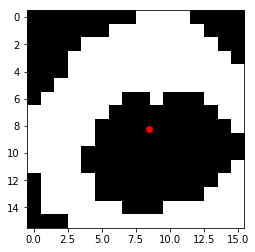

In [30]:
# going back to the image with only the contours (bin_inverted)

plt.imshow(bin_inverted, cmap = 'gray')
plt.plot(x_white, y_white, 'ro')

For each image, one needs to the determine the coordinates of the calculated centroid, so that when it is time to slice, the centroid is depicted in the sliced image. Once we have the desired image, we proceed to recalculate the white areas of the image (coordinates will be returned) and proceed to calculate the distance from the centroid to the white areas.

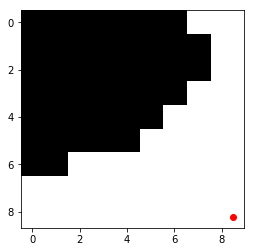

In [31]:
#let's play with the slicing
test_1 = bin_inverted[8:,8:]
plt.imshow(test_1, cmap = 'gray')
plt.plot(x_white,y_white, 'ro')


Although this seems like a good idea, once we slice the image, we lose track of the actual coordinates of the white areas whithin the full image.
The best idea right now would be to use "np.where"

### Distances Bottom Right

In [32]:
centr = x_white, y_white
centr

(8.480392156862745, 8.25)

The slicing needs to happen while all the coordinates are together.

In [33]:
bottom_right = coords_array[np.where(coords_array[:,0] > 7)]

Now we can proceed to calculate the distances from the centroid to the white areas, and then get the average?
Maybe from here we can get an estimation of the major and minor axis?

In [34]:
from scipy.spatial import distance
tuples_br = [(x,y) for x,y in bottom_right]
dummy = [centr for i in range(len(tuples_br))]
dist_bott_right = [distance.euclidean(centr, tuples_br[i]) for i in range(len(tuples_br))]
dist_bott_right

[8.263974626314825,
 7.26589819804649,
 6.268434942182557,
 5.2719329115965845,
 4.277064019204674,
 6.767072973182367,
 8.26634697497327,
 7.2685963095118815,
 6.271562190606879,
 5.2756508897623,
 4.281645981471349,
 8.388784655534094,
 7.4075439922368504,
 6.432084265378079,
 5.465501623540538,
 8.626176654996046,
 7.675345183325553,
 6.738762770954232,
 5.823308654296007,
 7.20492357233571,
 8.059164930032967,
 7.172875251213649,
 6.3206122622316645,
 5.518164492788637,
 6.741671852698949,
 7.612498891262532,
 8.543380774362559,
 7.71293427015606,
 6.927434954999418,
 6.203978969640999,
 6.556626804672337,
 7.313641709555356,
 8.12338322718729,
 9.112001467406724,
 8.33837938343071,
 7.617648636030825,
 6.966245096321425,
 6.405354849032355,
 5.960584765106717,
 5.7903860615698415,
 6.166730960729704,
 6.672973156099333,
 7.282071871522712,
 7.97048121144654,
 8.71943637754312,
 8.370650299008842,
 7.782530849813369,
 7.2847639926285055,
 6.8969403671698375,
 6.638357208549176,
 6.

### Distances Bottom Left

In [35]:
# recall your centroid
centr

(8.480392156862745, 8.25)

In [36]:
# x is now less than 9 (to include 8's) y's do not matter because 
bottom_left = coords_array[np.where(coords_array[:,0] < 9)]
tuples_bl = [(x,y) for x,y in bottom_left]
dist_bott_left = [distance.euclidean(centr, tuples_bl[j]) for j in range(len(tuples_bl))]
dist_bott_left

[8.484076327696442,
 8.513492299531325,
 8.659073341540605,
 8.91513046086142,
 7.811451006084188,
 7.584112790594142,
 7.4845685794475605,
 7.517896435869123,
 7.682367266699352,
 7.9698661733089144,
 8.367721722216489,
 7.749708543340723,
 7.249688442045505,
 6.859882105891338,
 6.599847157830868,
 6.485212603047658,
 6.523647944726032,
 6.712524302133153,
 7.039743071073559,
 7.4871878904384515,
 8.0347982243942,
 7.589281796916141,
 6.935214358114873,
 6.37159306555297,
 5.924288834366762,
 5.6211385139491705,
 5.486091340198657,
 5.531473419714018,
 5.753016442963004,
 6.131655420276215,
 6.640572128439137,
 7.252392584037539,
 7.94337448399625,
 6.90191378381947,
 6.175468717374998,
 5.535017062239032,
 5.013622829778602,
 4.651495875444501,
 4.487361572157653,
 4.542731984090323,
 4.810032627672832,
 5.257034704020623,
 5.842637578977255,
 6.529656490143812,
 7.289472812163936,
 8.101630322304098,
 7.15371438943097,
 6.298859386075523,
 5.49323489080448,
 4.761893485321958,
 4.1

### Distances Upper Right

In [37]:
# x's are still greater than 7 (to include 8s) and now y's are less than 9 (to include 8)
upper_right = coords_array[np.where((coords_array[:,0] > 7) & (coords_array[:,1] < 9))]
tuples_ur = [(x,y) for x,y in upper_right]
dist_up_right = [distance.euclidean(centr, tuples_ur[k]) for k in range(len(tuples_ur))]
dist_up_right

[8.263974626314825,
 7.26589819804649,
 6.268434942182557,
 5.2719329115965845,
 4.277064019204674,
 8.26634697497327,
 7.2685963095118815,
 6.271562190606879,
 5.2756508897623,
 4.281645981471349,
 8.388784655534094,
 7.4075439922368504,
 6.432084265378079,
 5.465501623540538,
 8.626176654996046,
 7.675345183325553,
 6.738762770954232,
 5.823308654296007,
 8.059164930032967,
 7.172875251213649,
 6.3206122622316645,
 5.518164492788637,
 8.543380774362559,
 7.71293427015606,
 6.927434954999418,
 6.203978969640999,
 9.112001467406724,
 8.33837938343071,
 7.617648636030825,
 6.966245096321425,
 6.405354849032355,
 5.960584765106717,
 8.370650299008842,
 7.782530849813369,
 7.2847639926285055,
 6.8969403671698375,
 6.638357208549176,
 6.524399315515322]

### Distances Upper Left


In [38]:
# x's are now less than 9(incl 8) and y also less than 9
upper_left = coords_array[np.where((coords_array[:,0] < 9) & (coords_array[:,1] < 9))]
tuples_ul = [(x,y) for x,y in upper_left]
dist_up_left = [distance.euclidean(centr, tuples_ul[p]) for p in range(len(tuples_ul))]
dist_up_left

[8.484076327696442,
 7.811451006084188,
 7.584112790594142,
 7.4845685794475605,
 7.749708543340723,
 7.249688442045505,
 6.859882105891338,
 6.599847157830868,
 6.485212603047658,
 7.589281796916141,
 6.935214358114873,
 6.37159306555297,
 5.924288834366762,
 5.6211385139491705,
 5.486091340198657,
 6.90191378381947,
 6.175468717374998,
 5.535017062239032,
 5.013622829778602,
 4.651495875444501,
 4.487361572157653,
 7.15371438943097,
 6.298859386075523,
 5.49323489080448,
 4.761893485321958,
 4.144349112412191,
 3.6980575395133743,
 3.4893594778342503,
 7.662561272304856,
 6.724198483970132,
 5.8064485920247515,
 4.920858182454176,
 4.088379294026695,
 3.3488573053843638,
 8.381769558876021,
 7.3995987011527005,
 6.422932425154474,
 5.45472831020031,
 4.500451192725095,
 3.571282814074059,
 8.263974626314825,
 7.26589819804649,
 6.268434942182557,
 5.2719329115965845,
 4.277064019204674]

In [39]:
len(dist_bott_left), len(dist_bott_right), len(dist_up_left), len(dist_up_right)

(84, 58, 45, 38)

#### Concatenate all lists of dists

In [40]:
type(dist_bott_left)

list

In [41]:
all_dists = dist_bott_left + dist_bott_right + dist_up_left + dist_up_right
all_dists

[8.484076327696442,
 8.513492299531325,
 8.659073341540605,
 8.91513046086142,
 7.811451006084188,
 7.584112790594142,
 7.4845685794475605,
 7.517896435869123,
 7.682367266699352,
 7.9698661733089144,
 8.367721722216489,
 7.749708543340723,
 7.249688442045505,
 6.859882105891338,
 6.599847157830868,
 6.485212603047658,
 6.523647944726032,
 6.712524302133153,
 7.039743071073559,
 7.4871878904384515,
 8.0347982243942,
 7.589281796916141,
 6.935214358114873,
 6.37159306555297,
 5.924288834366762,
 5.6211385139491705,
 5.486091340198657,
 5.531473419714018,
 5.753016442963004,
 6.131655420276215,
 6.640572128439137,
 7.252392584037539,
 7.94337448399625,
 6.90191378381947,
 6.175468717374998,
 5.535017062239032,
 5.013622829778602,
 4.651495875444501,
 4.487361572157653,
 4.542731984090323,
 4.810032627672832,
 5.257034704020623,
 5.842637578977255,
 6.529656490143812,
 7.289472812163936,
 8.101630322304098,
 7.15371438943097,
 6.298859386075523,
 5.49323489080448,
 4.761893485321958,
 4.1

#### Plot the dist plot of all distances

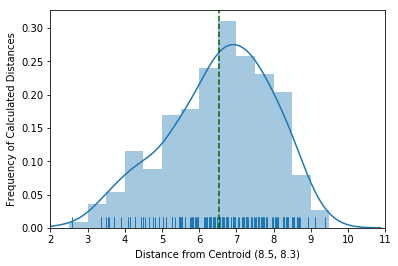

In [43]:
import seaborn as sns
mu = np.mean(all_dists)
sns.distplot(all_dists, bins = np.arange(0, 10.1, 0.5), rug = True)
plt.xlim(2,11)
plt.axvline(x = np.mean(all_dists), c = 'darkgreen', linestyle = '--')
plt.xlabel("Distance from Centroid (8.5, 8.3)")
plt.ylabel("Frequency of Calculated Distances");


#### The radius is now given by mu. 
We use the averaged radii to plot in the original image.

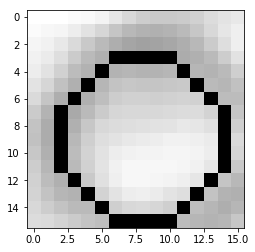

In [44]:
# recall that the fiber we had is ic_fiber[16]
u = np.zeros((20,20), dtype=np.uint8)
rr, cc = circle_perimeter(9,8, 6)
image[rr, cc] = 1
plt.imshow(image, cmap = 'gray')
plt.savefig("tryFibe")

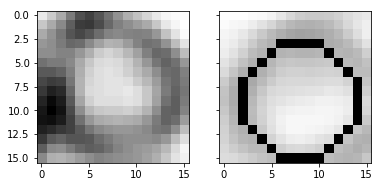

In [45]:
fi, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(ic_fiber[10], cmap = 'gray')
rr, cc = circle_perimeter(9,8, 6)
image[rr, cc] = 1
ax2.imshow(image, cmap ='gray')
plt.savefig('two')

### Finding Contours (coating)
Applying the find_boundaries algorithm from skimage.segmentation to find the edges of a created circle, a fake fiber, and one fiber.
This seems to promise us the possible calculation of the thickness of the coating within the fibers.

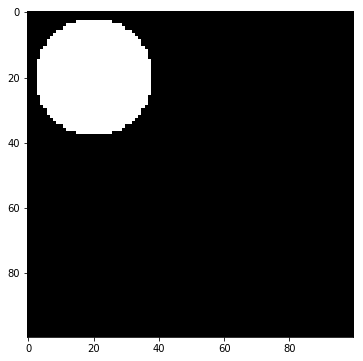

In [46]:
# create an image with no blobs to see what happens when you attempt (no error)
# to extract blobs from this image using the feature extractor we've been
# using, drew a blob and it also didnt detect any.
from skimage.draw import circle

dark_img = np.zeros([100,100],dtype=np.uint8)
fig4, axis = plt.subplots(ncols=1, nrows=1, figsize=(10,6))

rr2, cc2 = circle(20, 20, 18)
dark_img[rr2, cc2] = 1
axis.imshow(dark_img, cmap='gray')
blobsy_doh = blob_doh(dark_img)


In [47]:
blobsy_doh[:]

array([], shape=(0, 3), dtype=float64)

Okay, so something is definitely wrong, with the way you are implementing it. Possible errors:
1. The input is not what it should be
2. You are not using the parameters correctly

**Other possible methods to make the images better, or easily detect the borders.**
1. find_countours?
2. canny?
3. *Circular and Elliptical Hough Transforms*

In [48]:
dark_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [49]:
from skimage.segmentation import find_boundaries
labeled_img = dark_img
maybe = find_boundaries(labeled_img, mode= 'thick').astype(np.uint8)

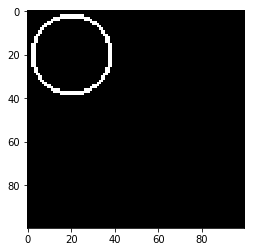

In [50]:
plt.imshow(maybe, cmap='gray')

In [51]:
# OMG IT WORKS

#### Will it work with the fake fiber?

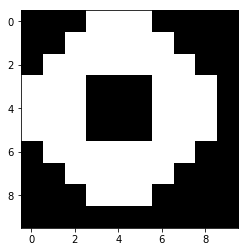

In [52]:
label_fake = img_circle
round_2 = find_boundaries(label_fake, mode= 'thick').astype(np.uint8)
plt.imshow(round_2, cmap='gray')

In [53]:
# OMG YES

#### Will it work in one fiber??

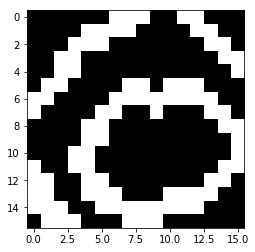

In [54]:
# Prior to everything I think you would want to invert the image
# so that it does not look like the one below the cell. 

label_fiber = bin_inverted
fiber_bound = find_boundaries(label_fiber, mode='thick').astype(np.uint8)
plt.imshow(fiber_bound, cmap='gray')

In this case the white edges are the coating of the fiber. We can use this to approximate the coating of the fiber.
1. np.where(pix are white) 
2. calculate the distand between these points? 
3. Establish a bound by comparison.

In [57]:
fiber_bound

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]], dtype=uint8)

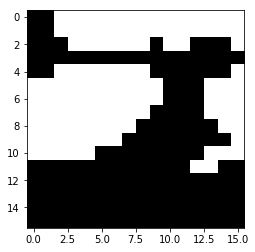

In [55]:
no_fib = io.ImageCollection("Data/no_fibers/*.tif")
first = no_fib[28]
first_thresh_val = threshold_otsu(first)
first_t = first > first_thresh_val
plt.imshow(first_t, cmap ='gray')

##### Try it with a "no fiber" image
If this method does end up detecting the borders...then is there any point on keeping this approach?

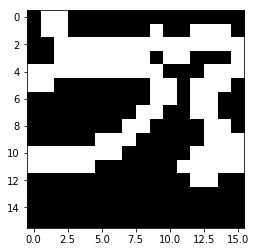

In [56]:
# invert it
test_no = np.invert(first_t)
no_bound = find_boundaries(test_no, mode = 'thick').astype(np.uint8)
plt.imshow(no_bound, cmap = 'gray')

Well by far, all the images with "borders detected" do not look like complete circles which can potentially aid in attempting to find circles in those images that DO NOT have fibers?

...let's keep inspecting

Questions arising:
1. Will the next algorithm be able to differentiate between a chopped-off fiber and the union of a few?
2. Will it only be looking for concentric circles?
3. More importantly, will it work with the images that **DO** contain fibers?